# Initial Setup

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import h2o

In [2]:
df = pd.read_excel("AML and ATF Modelling Assignment data_std.xlsx", sheet_name="data")
df.drop(columns=["cust_id_masked", "tot_acct_num.1"], inplace=True)

X = df.drop(columns=["rating"])
y = df["rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=2000)

# Feature Selection

In [3]:
rf = RandomForestClassifier(
    n_estimators=100, 
    criterion = "gini", 
    max_depth = None,
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_features = "sqrt",
    bootstrap = True,
    oob_score = False,
    random_state=2000,
    class_weight="balanced"
)
rf.fit(X_train, y_train)
print("training complete")

training complete


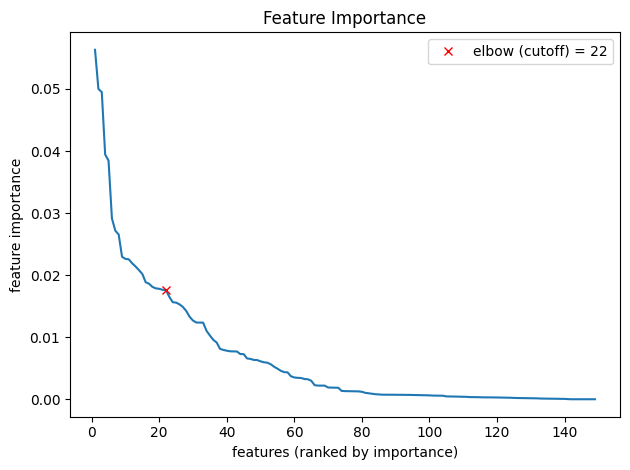

sum of feature importance up to 22 = 0.5953976714214462
1: cust_tenure
2: in_person_visit_cnt
3: prod_total_balance
4: prod_liability_balance
5: avg_cash_5m
6: prod_asset_balance
7: tot_cross_border_val_12m
8: txn_cash_in_avg_5m
9: prod_total_acct_cnt
10: avg_wire_12m
11: tot_acct_num
12: tot_cash_val_5m
13: txn_cash_out_avg_5m
14: prod_primary_cda_cnt
15: txn_cash_in_val_3m
16: prod_prim_acct_cnt
17: tot_cash_cnt_5m
18: txn_cash_in_avg_3m
19: txn_cash_out_val_5m
20: tot_cross_border_cnt_12m
21: txn_cash_out_cnt_5m
22: prod_primary_crc_cnt


In [4]:
sort_args = np.argsort(rf.feature_importances_)[::-1]
sorted_feature_importances = rf.feature_importances_[sort_args]
k = 22

fig, ax = plt.subplots()
ax.plot(list(range(1, len(sorted_feature_importances)+1)), sorted_feature_importances)
# ax.axvline(x=k, color='r', label=f"elbow = {k}", linestyle="dashed")
ax.plot(k, sorted_feature_importances[k-1], 'rx', label=f"elbow (cutoff) = {k}")
ax.set(xlabel='features (ranked by importance)', ylabel='feature importance')
ax.set_title("Feature Importance")
ax.legend()
plt.tight_layout()
plt.show()
fig.savefig("feature_importance.png")

print(f"sum of feature importance up to {k} = {np.cumsum(sorted_feature_importances)[k-1]}")

feature_cols = [col for col in df.columns if col != "rating"]
selected_feature_cols = []
for i, arg in enumerate(sort_args[:k]):
    print(f"{i+1}: {feature_cols[arg]}")
    selected_feature_cols.append(feature_cols[arg])

# Model Training

In [5]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_281"; Java(TM) SE Runtime Environment (build 1.8.0_281-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.281-b09, mixed mode)
  Starting server from /Users/joshuakim/Desktop/Graduate/MMF/FALL2022/MMF2000/Assignments/AML Risk/venv/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/9q/k_clqrv14pq2ky9p8tcrbdt00000gn/T/tmp6k41tama
  JVM stdout: /var/folders/9q/k_clqrv14pq2ky9p8tcrbdt00000gn/T/tmp6k41tama/h2o_joshuakim_started_from_python.out
  JVM stderr: /var/folders/9q/k_clqrv14pq2ky9p8tcrbdt00000gn/T/tmp6k41tama/h2o_joshuakim_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Toronto
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,"7 days, 16 hours and 10 minutes"
H2O_cluster_name:,H2O_from_python_joshuakim_waza7z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.542 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [6]:
train_hf = h2o.H2OFrame(pd.concat([X_train[selected_feature_cols], y_train], axis=1))
train_hf["rating"] = train_hf["rating"].asfactor()
test_hf = h2o.H2OFrame(pd.concat([X_test[selected_feature_cols], y_test], axis=1))
test_hf["rating"] = test_hf["rating"].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
# train using AutoML
aml = h2o.automl.H2OAutoML(max_models=50, sort_metric="logloss", seed=2000, exclude_algos=["DeepLearning", "StackedEnsemble"], balance_classes=True)
aml.train(training_frame=train_hf, y="rating")

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20221201_60531_model_58


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    31                 31                          5489                   4            4            4             6             12            9.45161

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.15740691758767547
RMSE: 0.39674540651112206
LogLoss: 0.4809590450810671
Mean Per-Class Error: 0.18869685167153522
AUC: 0.9051444336254463
AUCPR: 0.9113137518132396
Gini: 0.8102888672508926

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22302047654515866
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      214  98   0.3141   (98.0/312.0)
1      20   296  0.0633   (20.0/316.0)
Total  234  394  0.1879   (118.0/628.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.22302      0.833803  233
max f2                       0.172678     0.898415  270
max f0point5                 0.411868     0.849359  123
max accuracy                 0.289241     0.824841  188
max precision                0.896912     1         0
max recall                   0.119319     1         341
max specificity              0.896912     1         0
max absolute_mcc             0.289241     0.650215  188
max min_per_class_accuracy   0.302341     0.810127  179
max mean_per_class_accuracy  0.289241     0.824692  188
max tns                      0.896912     312       0
max fns                      0.896912     314       0
max fps                      0.0699683    312       399
max tps                      0.119319     316       341
max tnr                      0.896912     1         0
max fnr                      0.896912     0.993671  0
max fpr                      0.0699683    1         399
max tpr                      0.119319     1         341

Gains/Lift Table: Avg response rate: 50.32 %, avg score: 37.77 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0127389                   0.872983           1.98734   1.98734            1                0.883515   1                           0.883515            0.0253165       0.0253165                  98.7342   98.7342            0.0253165
2        0.022293                    0.862457           1.98734   1.98734            1                0.865347   1                           0.875729            0.0189873       0.0443038                  98.7342   98.7342            0.0443038
3        0.0318471                   0.846389           1.98734   1.98734            1                0.852511   1                           0.868763            0.0189873       0.0632911                  98.7342   98.7342            0.0632911
4        0.0414013                   0.831164           1.98734   1.98734            1                0.837078   1                           0.861451            0.0189873       0.0822785                  98.7342   98.7342            0.0822785
5        0.0509554                   0.817782           1.98734   1.98734            1                0.822004   1                           0.854

In [8]:
lb = aml.leaderboard
lb.head(rows=20)

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_1_20221201_60531_model_58,0.512722,0.777883,0.678541,0.265559,0.408292,0.166702
GBM_grid_1_AutoML_1_20221201_60531_model_38,0.518272,0.775611,0.670644,0.257587,0.411372,0.169227
GBM_grid_1_AutoML_1_20221201_60531_model_41,0.519393,0.773004,0.673249,0.268764,0.411584,0.169401
GBM_grid_1_AutoML_1_20221201_60531_model_27,0.520432,0.773136,0.666753,0.270529,0.412009,0.169751
GBM_grid_1_AutoML_1_20221201_60531_model_9,0.521992,0.772852,0.662752,0.267527,0.412923,0.170506
GBM_grid_1_AutoML_1_20221201_60531_model_63,0.523172,0.773825,0.646788,0.267608,0.414251,0.171604
GBM_grid_1_AutoML_1_20221201_60531_model_52,0.523561,0.766766,0.676464,0.295014,0.414346,0.171682
GBM_grid_1_AutoML_1_20221201_60531_model_4,0.523681,0.778471,0.654565,0.288401,0.415667,0.172779
GBM_grid_1_AutoML_1_20221201_60531_model_45,0.526786,0.769352,0.663817,0.296738,0.416139,0.173172
GBM_grid_1_AutoML_1_20221201_60531_model_54,0.530418,0.761127,0.65788,0.276574,0.417922,0.174659


In [9]:
# select the best model
best_model = aml.get_best_model()
model_path = h2o.save_model(model=best_model, path="models", force=True)
model_path

'/Users/joshuakim/Desktop/Graduate/MMF/FALL2022/MMF2000/Assignments/AML Risk/models/GBM_grid_1_AutoML_1_20221201_60531_model_58'

# Model Evaluation

In [21]:
perf = best_model.model_performance(test_hf)
perf

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.15032373900417384
RMSE: 0.38771605461235914
LogLoss: 0.46565243891624375
Mean Per-Class Error: 0.19038461538461537
AUC: 0.8522435897435897
AUCPR: 0.7494726248027876
Gini: 0.7044871794871794

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24801283432556753
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   18   0.2308   (18.0/78.0)
1      6    34   0.15     (6.0/40.0)
Total  66   52   0.2034   (24.0/118.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.248013     0.73913   51
max f2                       0.230992     0.810185  55
max f0point5                 0.385976     0.762195  30
max accuracy                 0.385976     0.822034  30
max precision                0.900722     1         0
max recall                   0.0899007    1         106
max specificity              0.900722     1         0
max absolute_mcc             0.248013     0.590413  51
max min_per_class_accuracy   0.254438     0.794872  47
max mean_per_class_accuracy  0.248013     0.809615  51
max tns                      0.900722     78        0
max fns                      0.900722     39        0
max fps                      0.0609533    78        114
max tps                      0.0899007    40        106
max tnr                      0.900722     1         0
max fnr                      0.900722     0.975     0
max fpr                      0.0609533    1         114
max tpr                      0.0899007    1         106

Gains/Lift Table: Avg response rate: 33.90 %, avg score: 29.89 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0169492                   0.861791           2.95      2.95               1                0.883547   1                           0.883547            0.05            0.05                       195       195                0.05
2        0.0254237                   0.833019           2.95      2.95               1                0.839423   1                           0.868839            0.025           0.075                      195       195                0.075
3        0.0338983                   0.815761           0         2.2125             0                0.820586   0.75                        0.856776            0               0.075                      -100      121.25             0.0621795
4        0.0423729                   0.785012           2.95      2.36               1                0.811124   0.8                         0.847646            0.025           0.1                        195       136                0.0871795
5        0.0508475                   0.767642           2.95      2.45833            1                0.772724   0.833333                    0.835159            0.025           0.125                      195       145.833            0.112179
6        0.101695                    0.676044           2.45833   2.45833            0.833333         0.723753   0.833333                    0.779456            0.125           0.25                       145.833   145.833            0.224359
7        0.152542                    0.629575           2.45833   2.45833            0.833333         0.653648   0.833333                    0.73752             0.125           0.375                      145.833   145.833            0.336538
8        0.20339                     0.471443           1.96

In [43]:
# test performance on the training set threshold 
pred_hf = best_model.predict(test_hf)
print(f"accuracy = ", accuracy_score(test_hf.as_data_frame()["rating"], pred_hf.as_data_frame()["predict"]))
print(f"F1 score = ", f1_score(test_hf.as_data_frame()["rating"], pred_hf.as_data_frame()["predict"]))
print(f"precision = ", precision_score(test_hf.as_data_frame()["rating"], pred_hf.as_data_frame()["predict"]))
print(f"recall = ", recall_score(test_hf.as_data_frame()["rating"], pred_hf.as_data_frame()["predict"]))

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
accuracy =  0.7542372881355932
F1 score =  0.707070707070707
precision =  0.5932203389830508
recall =  0.875


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GBM_grid_1_AutoML_1_20221201_60531_model_8,0.999544,0.101169,0.99915,0.00949367,0.121447,0.0147495,205,0.032148,GBM
GBM_grid_1_AutoML_1_20221201_60531_model_47,0.997718,0.164372,0.996493,0.0158228,0.180555,0.0326,173,0.020989,GBM
GBM_grid_1_AutoML_1_20221201_60531_model_34,0.997627,0.182563,0.996017,0.0237545,0.197345,0.0389449,137,0.037995,GBM
XRT_1_AutoML_1_20221201_60531,0.997616,0.123294,0.996275,0.0127394,0.157989,0.0249606,358,0.022048,DRF
GBM_grid_1_AutoML_1_20221201_60531_model_53,0.997454,0.161804,0.996267,0.0142608,0.179078,0.032069,145,0.025448,GBM
DRF_1_AutoML_1_20221201_60531,0.997343,0.12546,0.996051,0.0205899,0.158532,0.0251323,596,0.041383,DRF
GBM_grid_1_AutoML_1_20221201_60531_model_11,0.996754,0.185687,0.995025,0.0190685,0.201754,0.0407048,119,0.050425,GBM
GBM_grid_1_AutoML_1_20221201_60531_model_35,0.996298,0.215282,0.994229,0.0269596,0.226389,0.0512521,88,0.035478,GBM
GBM_grid_1_AutoML_1_20221201_60531_model_7,0.995791,0.199422,0.99365,0.0237545,0.212266,0.0450568,124,0.034645,GBM
XGBoost_grid_1_AutoML_1_20221201_60531_model_5,0.995791,0.148528,0.993583,0.0269596,0.179225,0.0321216,97,0.014902,XGBoost


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_grid_1_AutoML_1_20221201_60531_model_58

,0,1,Error,Rate
0,250.0,62.0,0.1987,(62.0/312.0)
1,24.0,134.0,0.1519,(24.0/158.0)
Total,274.0,196.0,0.183,(86.0/470.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

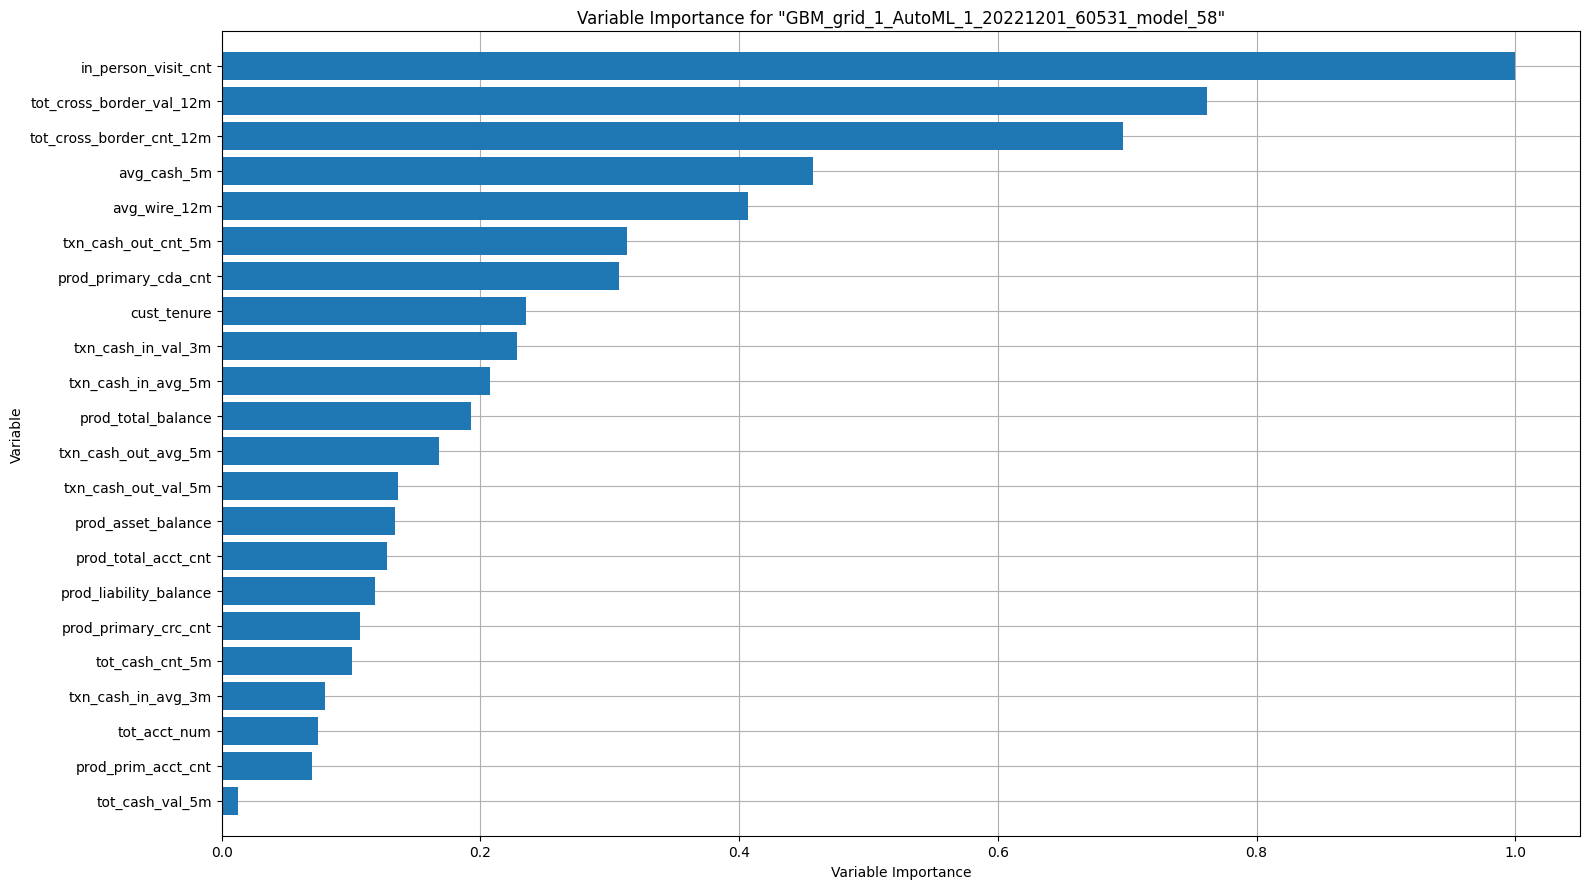

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

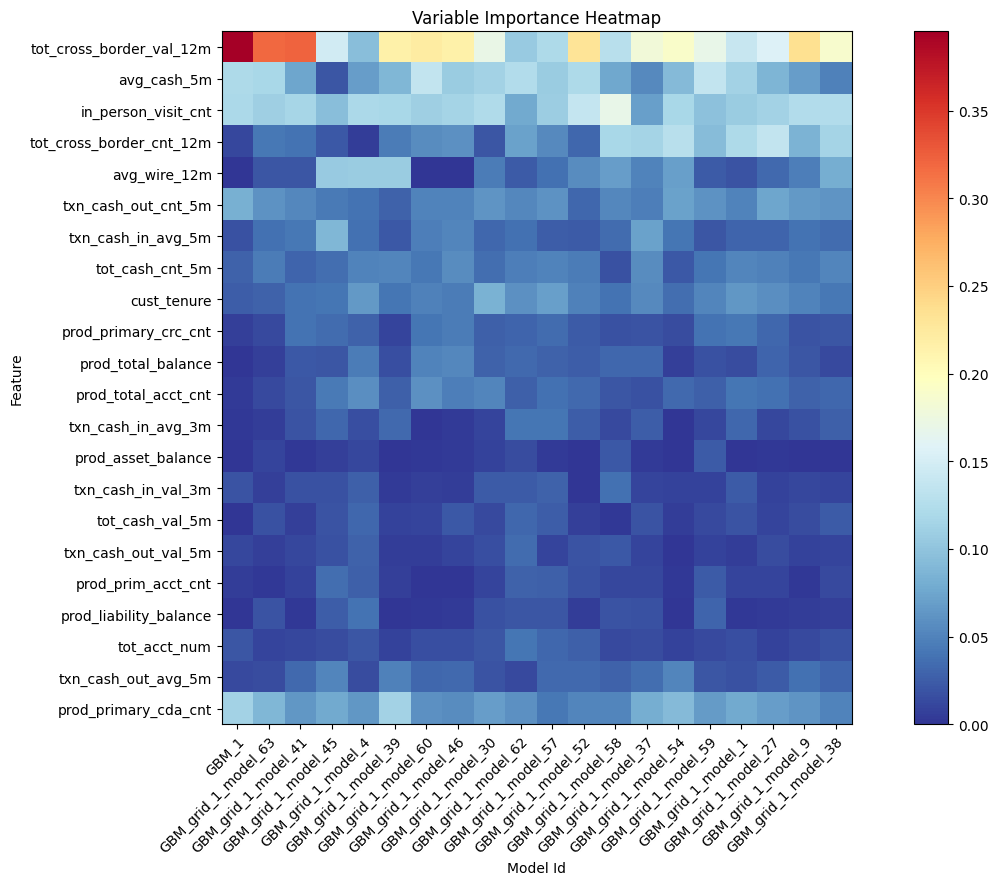

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

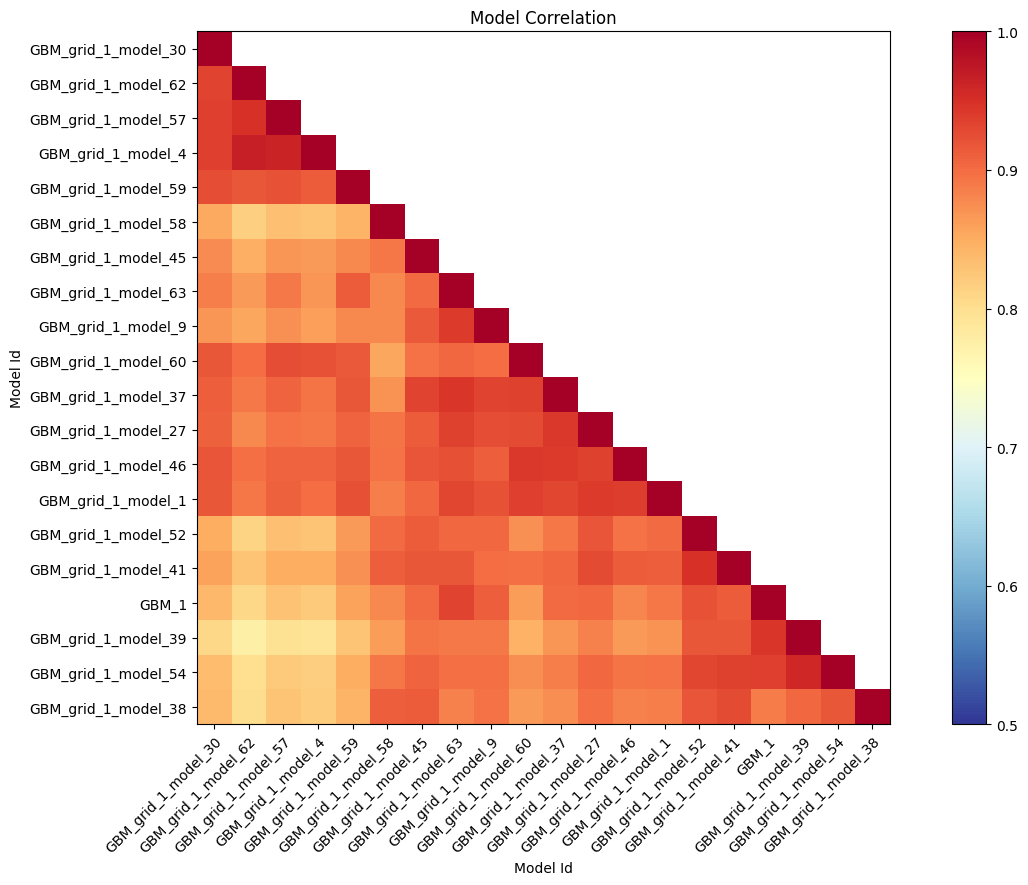

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

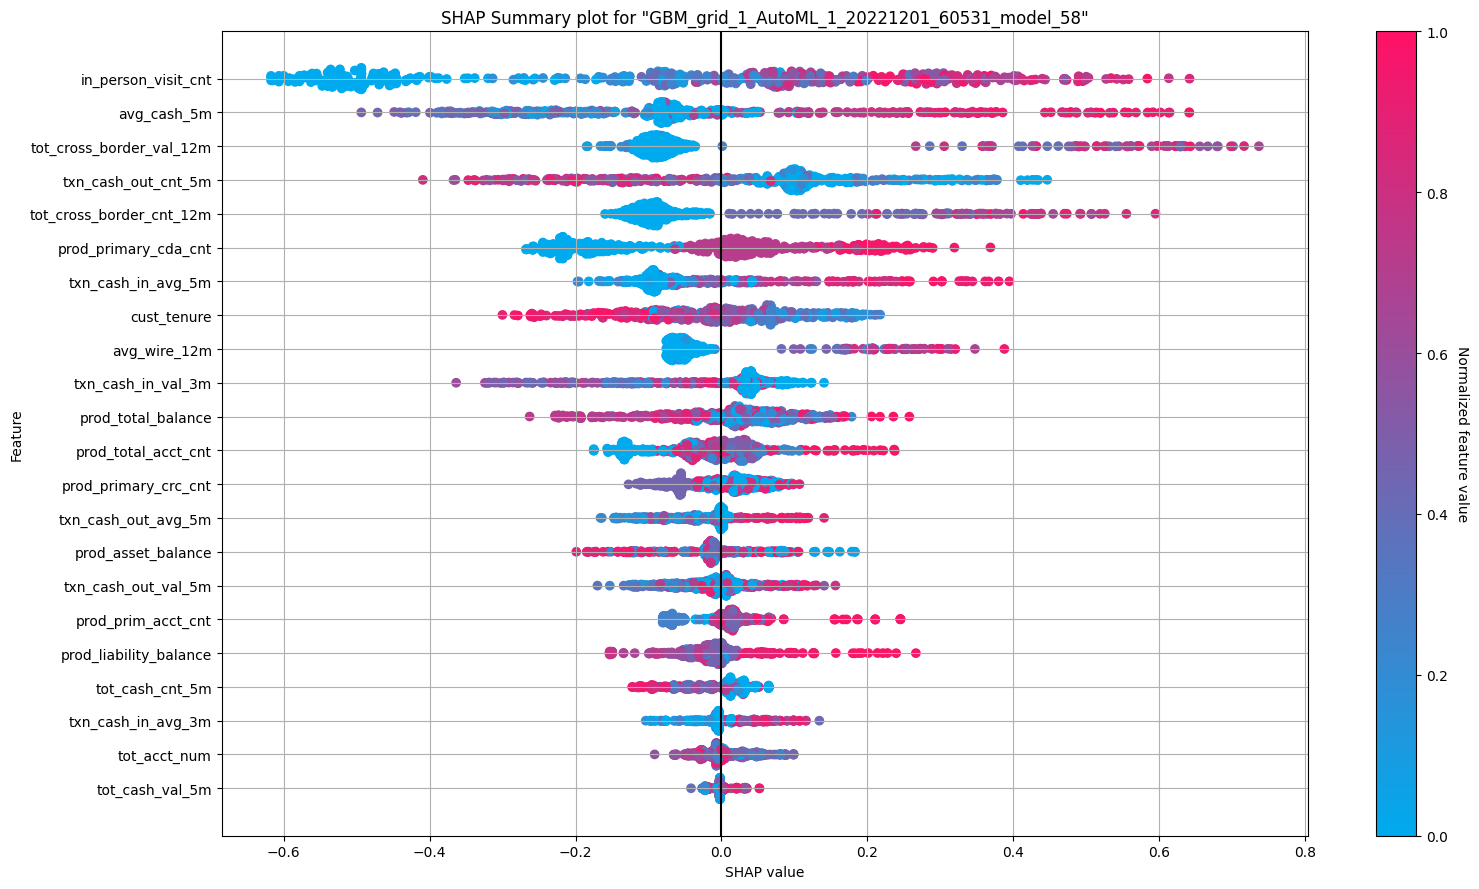

In [11]:
exa_train = aml.explain(train_hf, exclude_explanations=["pdp"], plot_overrides={"varimp_plot": {"num_of_features": k}, "varimp_heatmap": {"num_of_features": k}, "shap_summary_plot": {"top_n_features": k}}, figsize=(16, 9)) 

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GBM_grid_1_AutoML_1_20221201_60531_model_55,0.885577,0.437407,0.801934,0.183333,0.374732,0.140424,98,0.072386,GBM
GBM_grid_1_AutoML_1_20221201_60531_model_2,0.881731,0.424584,0.806919,0.157051,0.365607,0.133669,100,0.052244,GBM
GBM_grid_1_AutoML_1_20221201_60531_model_49,0.876603,0.450761,0.780884,0.183013,0.383075,0.146747,111,0.06875,GBM
GBM_2_AutoML_1_20221201_60531,0.871314,0.450685,0.786192,0.171154,0.380805,0.145012,355,0.076219,GBM
GBM_grid_1_AutoML_1_20221201_60531_model_40,0.870513,0.463223,0.766434,0.189744,0.390054,0.152142,95,0.065441,GBM
GBM_grid_1_AutoML_1_20221201_60531_model_4,0.870513,0.47173,0.731365,0.157372,0.392232,0.153846,109,0.070616,GBM
XGBoost_grid_1_AutoML_1_20221201_60531_model_4,0.870353,0.459026,0.758468,0.178205,0.373042,0.13916,140,0.088918,XGBoost
GBM_grid_1_AutoML_1_20221201_60531_model_35,0.86859,0.465734,0.787062,0.178205,0.392236,0.153849,88,0.072043,GBM
XGBoost_grid_1_AutoML_1_20221201_60531_model_11,0.867949,0.441011,0.754676,0.164744,0.375865,0.141275,78,0.096383,XGBoost
GBM_grid_1_AutoML_1_20221201_60531_model_42,0.866506,0.447982,0.792959,0.170513,0.378556,0.143304,85,0.061917,GBM


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_grid_1_AutoML_1_20221201_60531_model_58

,0,1,Error,Rate
0,60.0,18.0,0.2308,(18.0/78.0)
1,6.0,34.0,0.15,(6.0/40.0)
Total,66.0,52.0,0.2034,(24.0/118.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

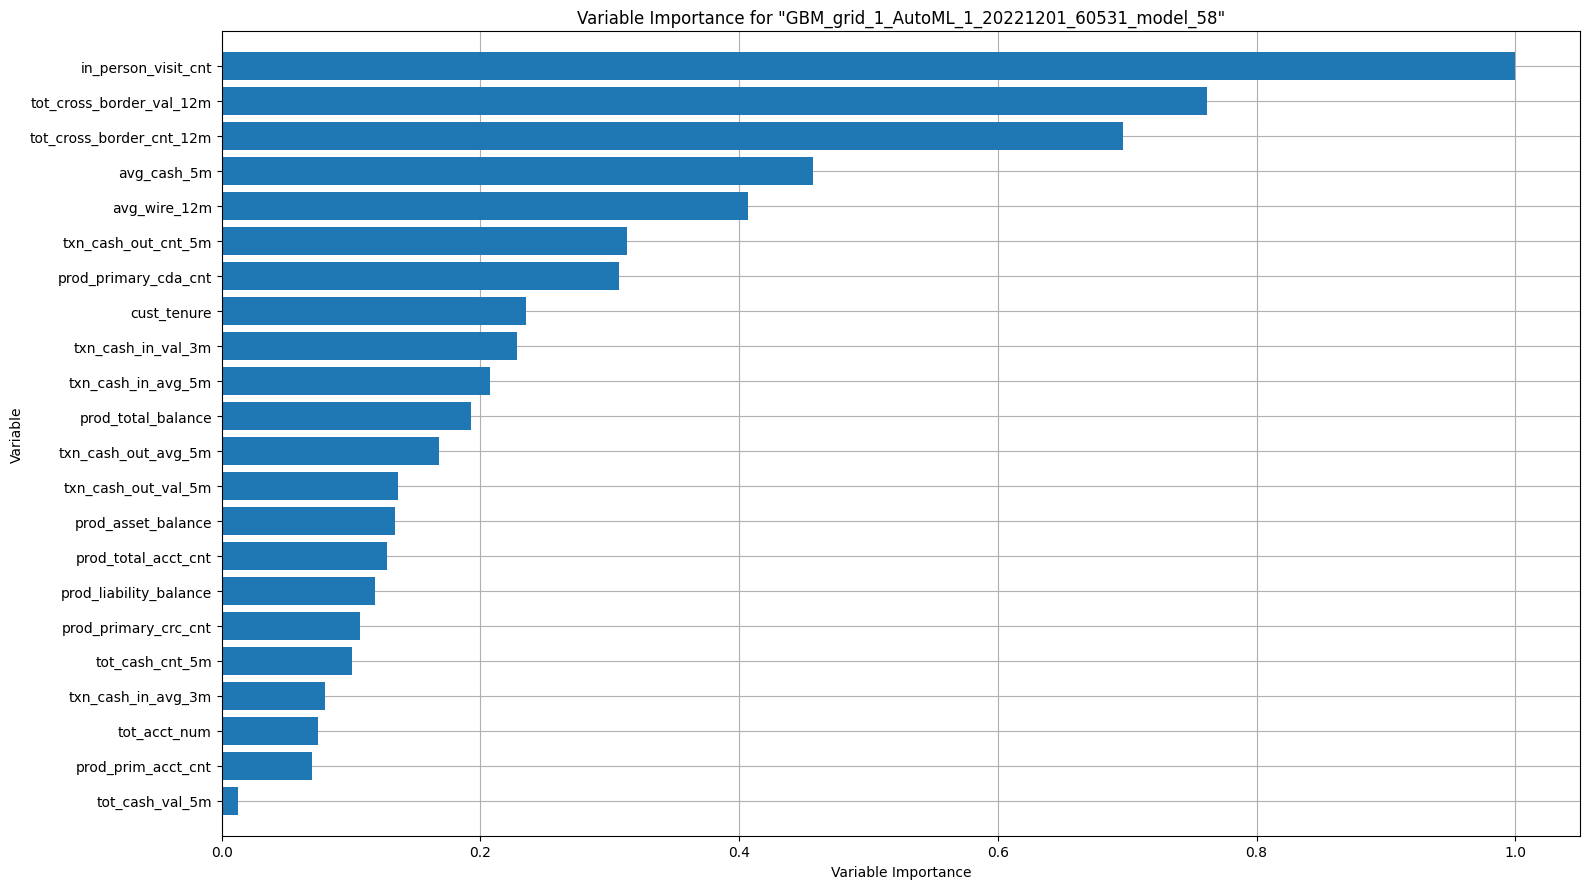

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

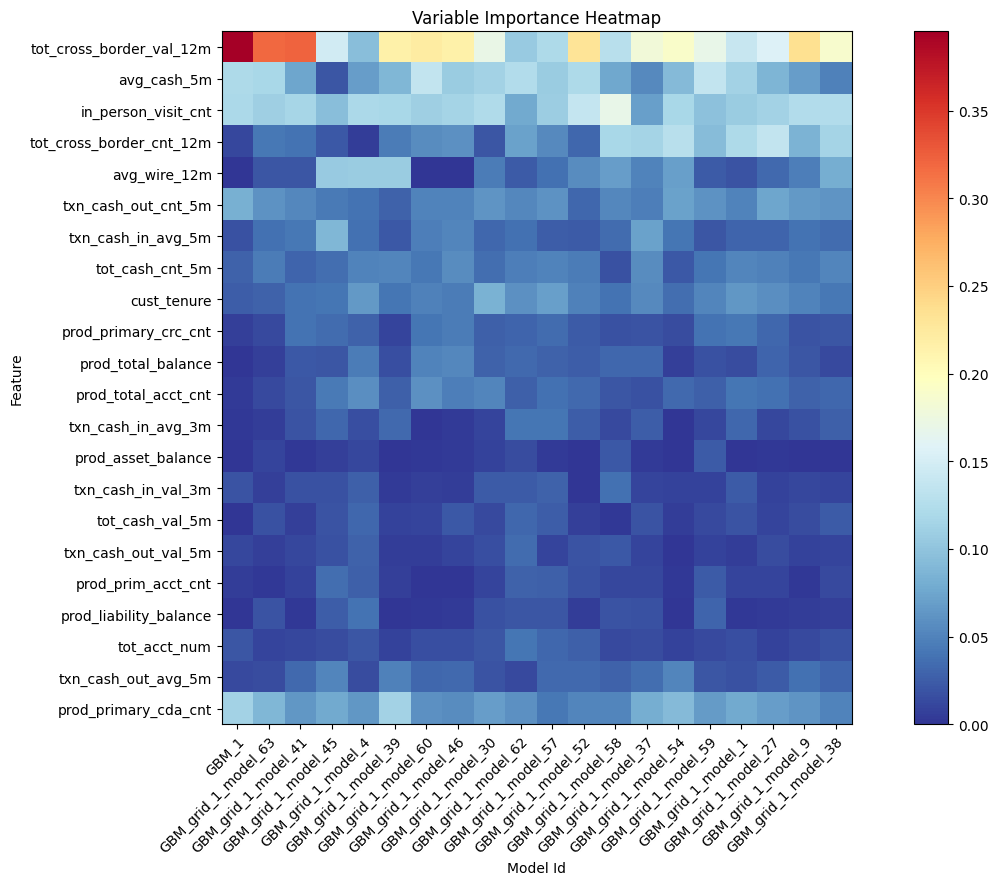

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

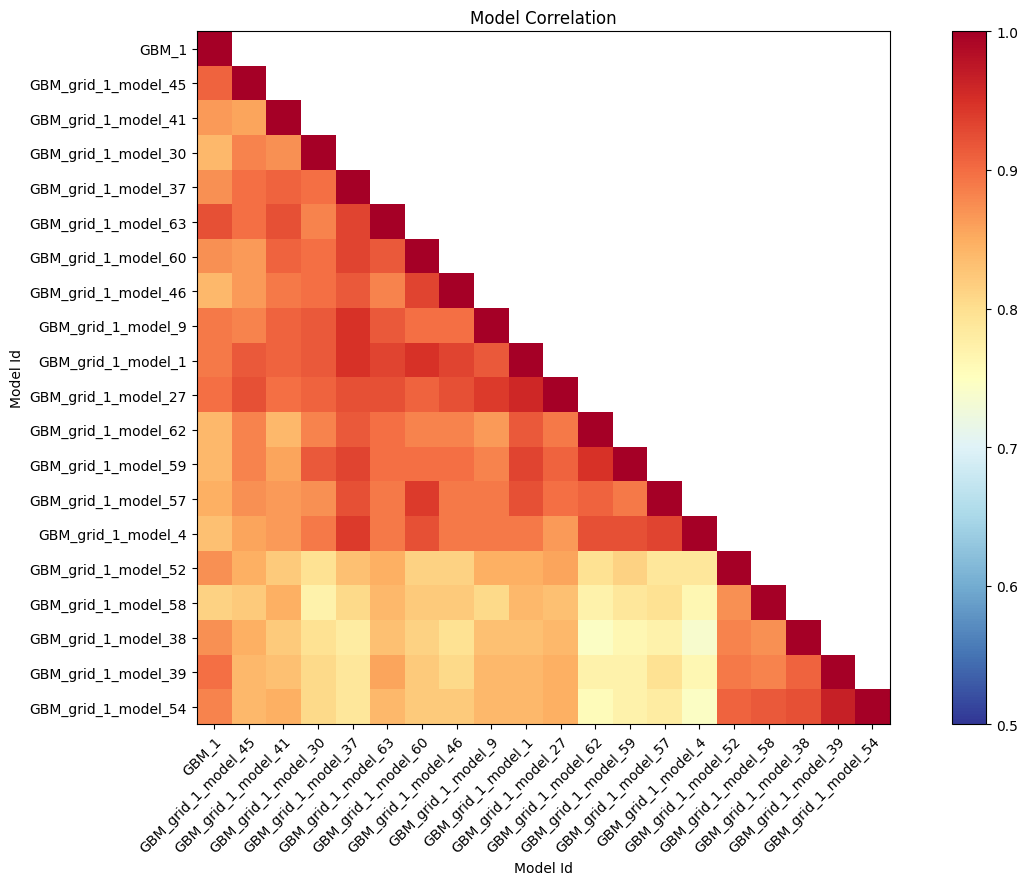

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

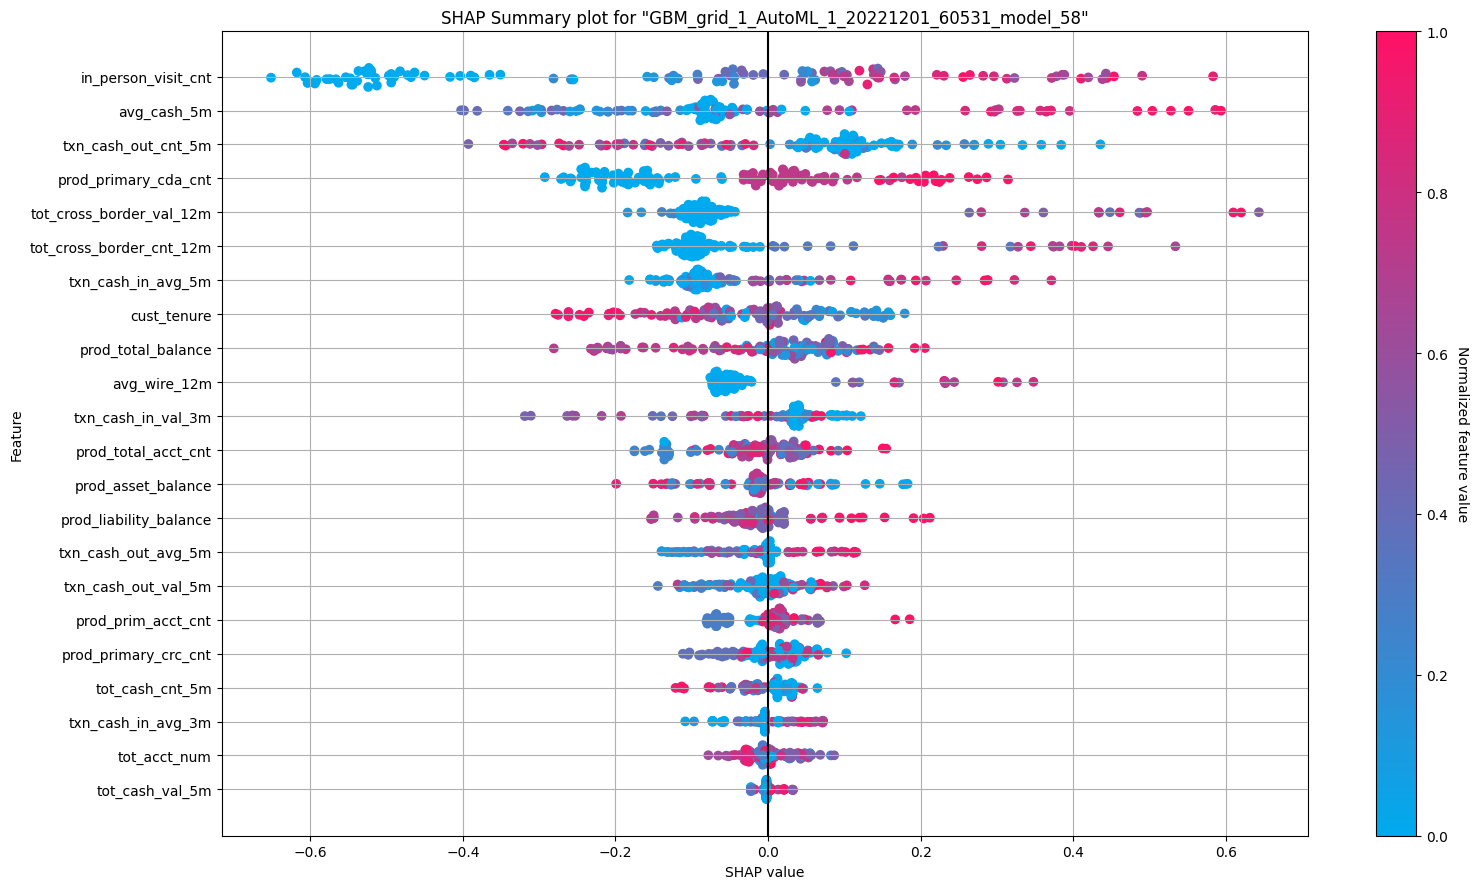

In [12]:
# explain all AutoML models
exa_test = aml.explain(test_hf, exclude_explanations=["pdp"], plot_overrides={"varimp_plot": {"num_of_features": k}, "varimp_heatmap": {"num_of_features": k}, "shap_summary_plot": {"top_n_features": k}}, figsize=(16, 9)) 

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_grid_1_AutoML_1_20221201_60531_model_58

,0,1,Error,Rate
0,60.0,18.0,0.2308,(18.0/78.0)
1,6.0,34.0,0.15,(6.0/40.0)
Total,66.0,52.0,0.2034,(24.0/118.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

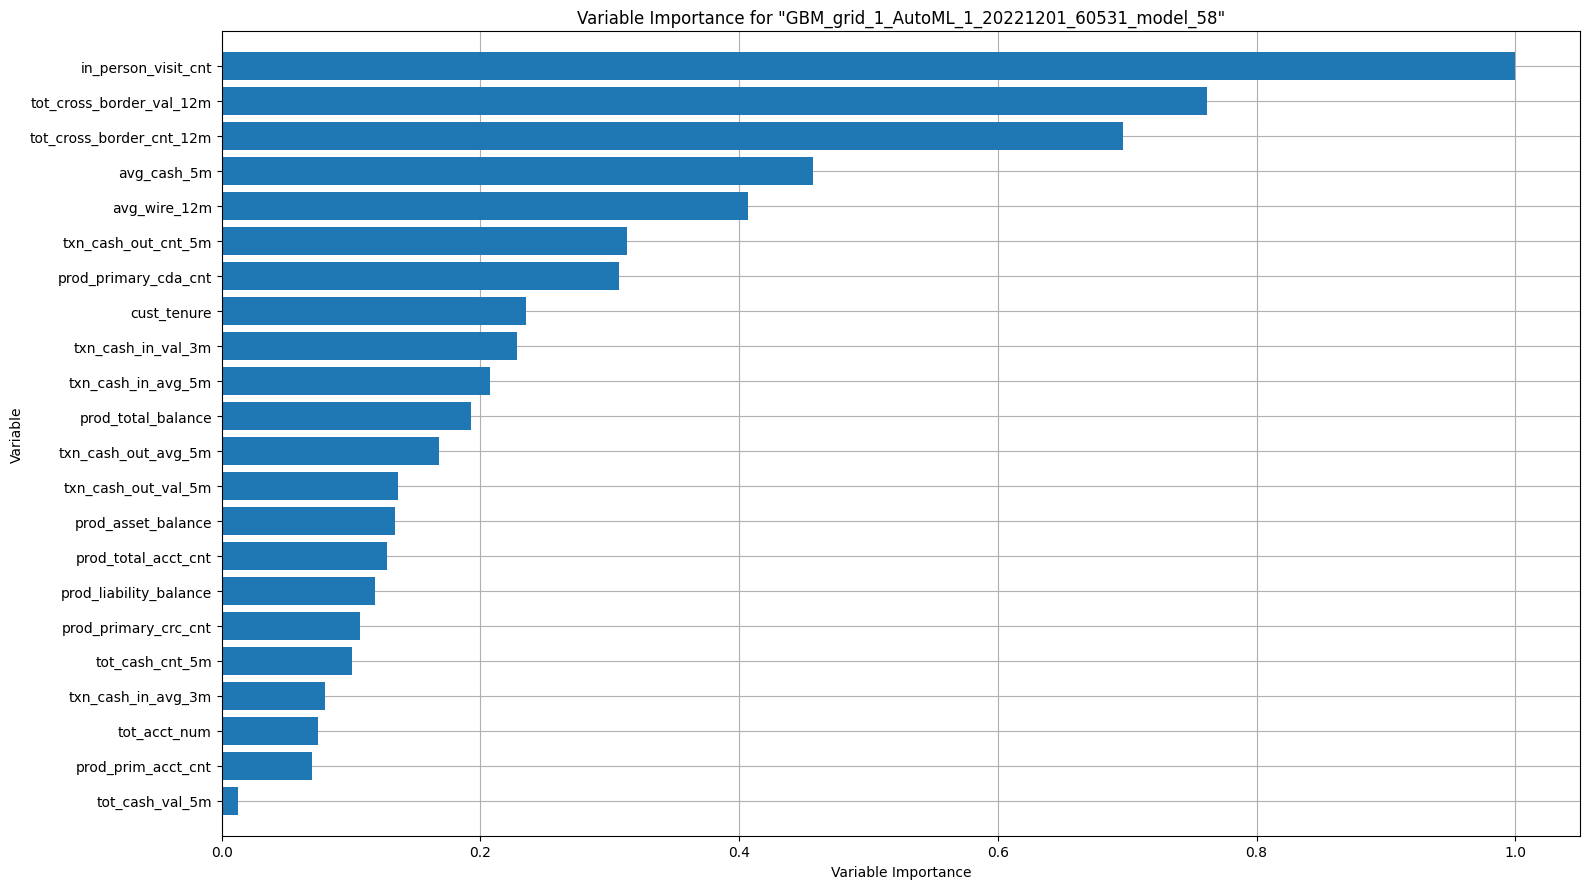

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

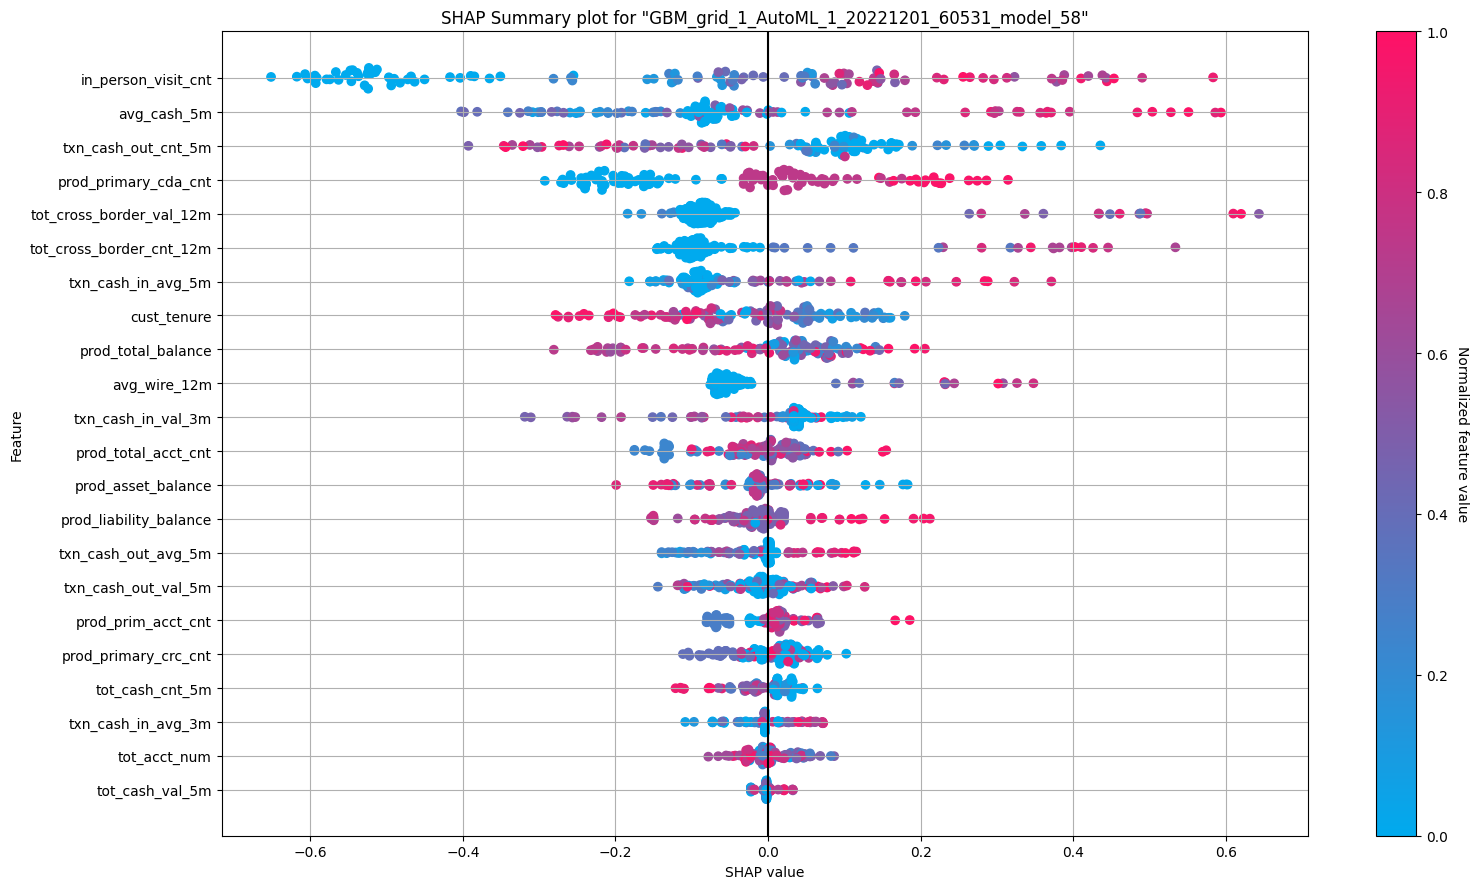

In [13]:
# explain a single model
exm = best_model.explain(test_hf, exclude_explanations=["pdp"], plot_overrides={"varimp_plot": {"num_of_features": 29}, "shap_summary_plot": {"top_n_features": 29}}, figsize=(16, 9))